In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn.objects as so
import numpy as np


# Define the path to the logs directory
logs_dir = '../logs/quirky'

# Walk through the directory

filters = {
    'rand_vs_nonrand': lambda root, dirs, files: 'eval.json' in files and 'probe_trajectory' in os.path.basename(root) and
     ('-rand_retrain' in os.path.basename(root) or 'nrand_retrain2' in os.path.basename(root) or '--' in os.path.basename(root)),
    'layerwise_activations': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and 'activations' in os.path.basename(root),
    'layerwise_agnostic': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and ('e2h' in root or 'Mistral' in root) and 'capitals' not in root and 'authors' not in root and
    ('activations' in root or 'iterative_rephrase' in root or 'attribution' in root),
}
def get_data(filter, train_from_test=False):
    results = []
    for root, dirs, files in os.walk(logs_dir):
        if filter(root, dirs, files):
            # Load the main eval.json
            main_eval_path = os.path.join(root, 'eval.json')
            with open(main_eval_path, 'r') as f:
                main_eval = json.load(f)
            
            if 'probe-probe' in root and 'cprobe' not in root:
                continue

            if 'squaring' in root:
                continue

            # Load the train_from_test eval.json
            if train_from_test:
                train_eval_path = os.path.join(root, 'train_from_test', 'eval.json')
                with open(train_eval_path, 'r') as f:
                    train_eval = json.load(f)
            # Extract dataset name from the folder structure    
            name_parts = os.path.basename(root).split('-')
            dataset = name_parts[0]
            score = name_parts[1]
            features = None
            alpha = None
            layer = None
            if len(name_parts) > 2:
                features = name_parts[2]
            if name_parts[-1].isdigit():
                alpha = int(name_parts[-1])
            rand = 0 if 'nrand' in os.path.basename(root) else 1
             
            if features == 'attribution':
                if 'appended' in root:
                    score = 'activation-attribution\n' + score + '-' + name_parts[-1] + '-old'
                elif 'refactor' not in root:
                    score = 'attribution-' + score + '\n' + name_parts[-1] + '-old'
                else:
                    score = 'attribution-' + score + '\n' + name_parts[-1]
            # Append the results to the list
            if 'all' in main_eval:
                if len(name_parts) > 4:
                    if 'Mistral' in root:
                        layer = (int(name_parts[5]) + int(name_parts[6]))/2
                    else:
                        layer = (int(name_parts[4]) + int(name_parts[5]))/2
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'random_names': rand,
                    'auc_roc': main_eval['all']['AUC_ROC'],
                    'auc_roc_agree': main_eval['all']['AUC_ROC_AGREE'],
                    'auc_roc_disagree': main_eval['all']['AUC_ROC_DISAGREE'],
                })
            else:
                for key, value in main_eval.items():
                    if key == 'out':
                        layer = '32'
                    else:
                        layer = re.findall(r'\d+', key)[0]
                    results.append({
                        'alpha': alpha,
                        'dataset': dataset,
                        'score': score,
                        'features': features,
                        'layer': layer,
                        'random_names': rand,
                        'auc_roc': value['AUC_ROC'],
                        'auc_roc_agree': value['AUC_ROC_AGREE'],
                        'auc_roc_disagree': value['AUC_ROC_DISAGREE'],
                    })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    # Order the datasets
    dataset_order = [
        'population', 
        'nli', 
        'sciq', 
        'sentiment',  
        'hemisphere',  
        'addition', 
        'subtraction', 
        'multiplication', 
        'modularaddition', 
        'squaring'
    ]

    score_order = [
        'que', 
        'likelihood', 
        'em', 
        'lof', 
        'mahalanobis', 
        'isoforest', 
        'attribution-mahalanobis\nmean',
        'attribution-mahalanobis\npcs',
        'attribution-mahalanobis\nraw',
        'attribution-mahalanobis\nedge_mean',
        'attribution-mahalanobis\ngrad_norm',
        'activation-attribution\nmahalanobis-mean', 
        'attribution-mahalanobis\nmean-old',
        'probe', 
        'rephrase', 
        'misconception'
    ]

    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)

    df = df.drop_duplicates(subset=['dataset', 'score', 'layer'])

    return df

def barplot_by_dataset(df, compare='random_names', disagree=False):
    if disagree:
        y_col = 'auc_roc_disagree'
        title = f'Mean AUC-ROC by Dataset and {compare} (only where Alice/Bob disagree)'
    else:
        y_col = 'auc_roc'
        title = f'Mean AUC-ROC by Dataset and {compare}'
    grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='dataset', ascending=True)
    # Create the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dataset', y=y_col, hue=compare, data=grouped_df)

    plt.title(title)
    plt.xlabel('Dataset')
    plt.ylabel('Alice vs Bob AUC')
    plt.legend(title=compare)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'auc_roc_all': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
    }

def plot_auc_roc_by_layer_by_score(
        df, 
        score_types=[
            'que', 
            'likelihood', 
            'em', 
            'lof', 
            'mahalanobis', 
            'isoforest', 
            'attribution-mahalanobis\nmean',
            'attribution-mahalanobis\npcs',
            'attribution-mahalanobis\nraw',
            'attribution-mahalanobis\nedge_mean',
            'attribution-mahalanobis\ngrad_norm',
            'activation-attribution\nmahalanobis-mean', 
            'attribution-mahalanobis\nmean-old',
            'probe destabilization', 
            'rephrase', 
            'misconception'
        ],
        multilayer=True,
        disagree=False):
    df['layer']=df['layer'].astype(int)
    df = df[df['score'].isin(score_types)]

    if disagree:
        y_col = 'auc_roc_disagree'
        title = '{} (disagree only)'
    else:
        y_col = 'auc_roc'
        title = '{} (all examples)'

    if multilayer:
        df = df[df['layer'] >= 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        df['title'] = df['score'].astype(str) + ' ' + title
        df = df.sort_values(by=['dataset', 'layer'])
        g = (
            so.Plot(df, x="layer", y=y_col, color="dataset", marker="dataset")
            .facet(col="score", wrap=3)
            .add(so.Line(), so.Agg(), so.Jitter(x=2))
            .label(x="Layer", y="Alice vs Bob AUC", title=title.format)
            .theme({
                "figure.figsize": (12, 12),
            })
        )
    else:
        df = df[df['layer'] < 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        unique_scores = df['score'].unique()
        n_scores = len(unique_scores)
        
        fig, ax = plt.subplots(1,1, figsize=(20, 12))  # Increased figure size
        for score in unique_scores:
            plot_df = df[df['score'] == score].sort_values(by=['dataset', 'layer'])
            
            g = sns.barplot(data=plot_df, x="dataset", y="auc_roc", ax=ax, hue="dataset", dodge=False)
    
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
        ax.set_ylim(df['auc_roc'].min()*0.9, 1.03)
        ax.set_xlabel(None)
        ax.set_title('AUC-ROC by Dataset for Different Scores')


        plt.tight_layout()
        plt.show()
        # axes = axes.flatten()
        
        # for idx, score in enumerate(unique_scores):
        #     ax = axes[idx]
        #     plot_df = df[df['score'] == score]
            
        #     g = sns.barplot(data=plot_df, x="dataset", y="auc_roc", ax=ax, hue="dataset", dodge=False)
        #     ax.set_title(score)
        #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        #     ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
        #     ax.set_ylim(plot_df['auc_roc'].min()*0.9, 1.03)
        #     ax.set_xlabel(None)
            
        # plt.tight_layout()
        # plt.subplots_adjust(top=0.9)  # Add space for the main title
        # fig.suptitle('AUC-ROC by Dataset for Different Scores', fontsize=16)

    return g


/tmp/ipykernel_2723118/1099315873.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()


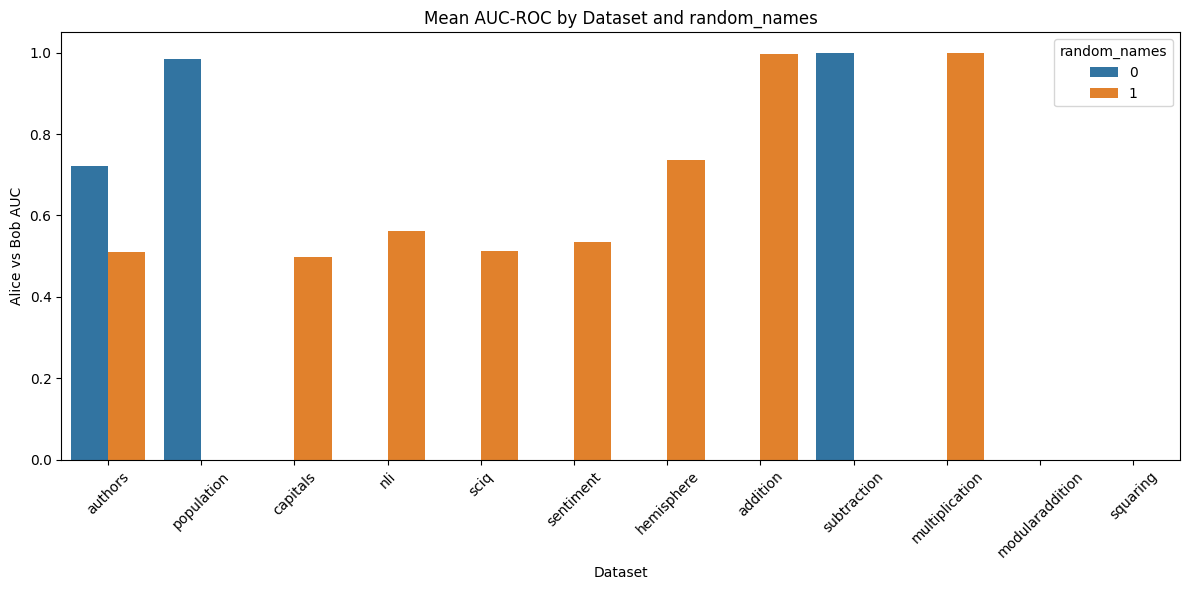

In [2]:
df = get_data(filters['rand_vs_nonrand'])
barplot_by_dataset(df[~df['dataset'].isin(['modularaddition', 'squaring'])], compare='random_names')

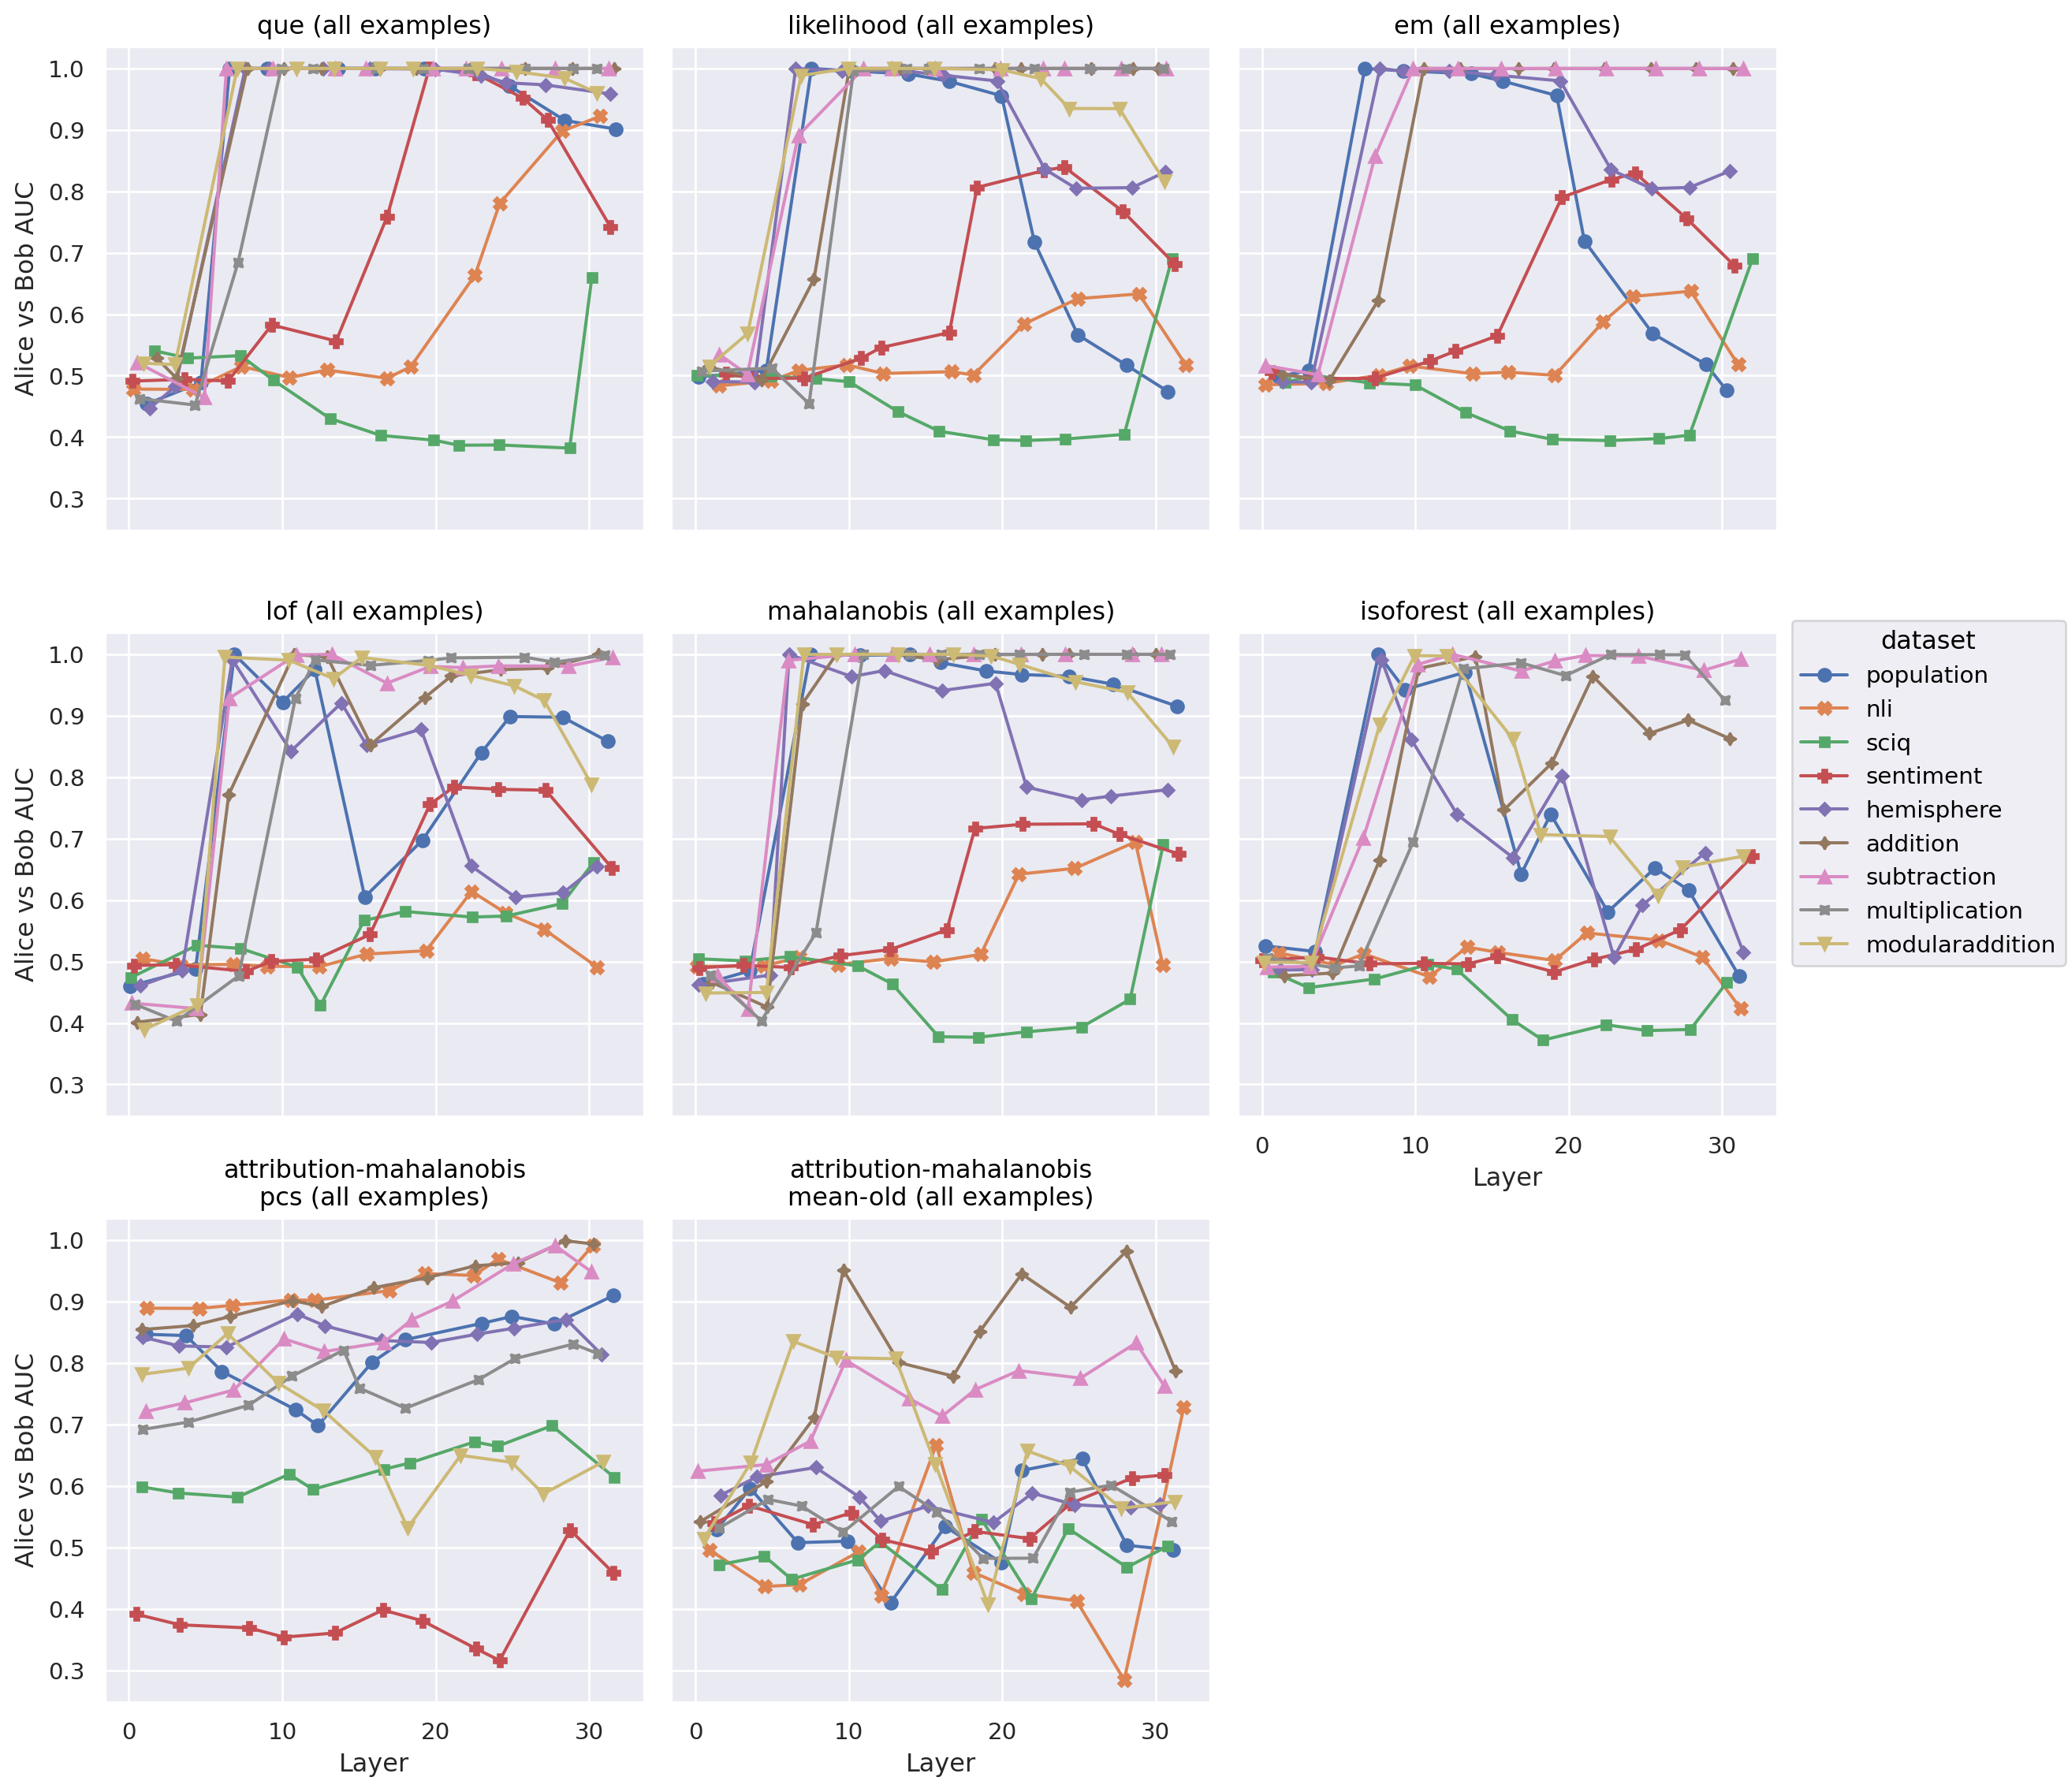

In [25]:
df = get_data(filters['layerwise_agnostic'])
df.loc[df['score'].isin(['rephrase']), 'layer'] = -1
df['score'] = df['score'].cat.add_categories('probe destabilization')
df.loc[df['score'] == 'probe', 'score'] = 'probe destabilization'
df['score'] = df['score'].cat.remove_unused_categories()

plot_auc_roc_by_layer_by_score(df)

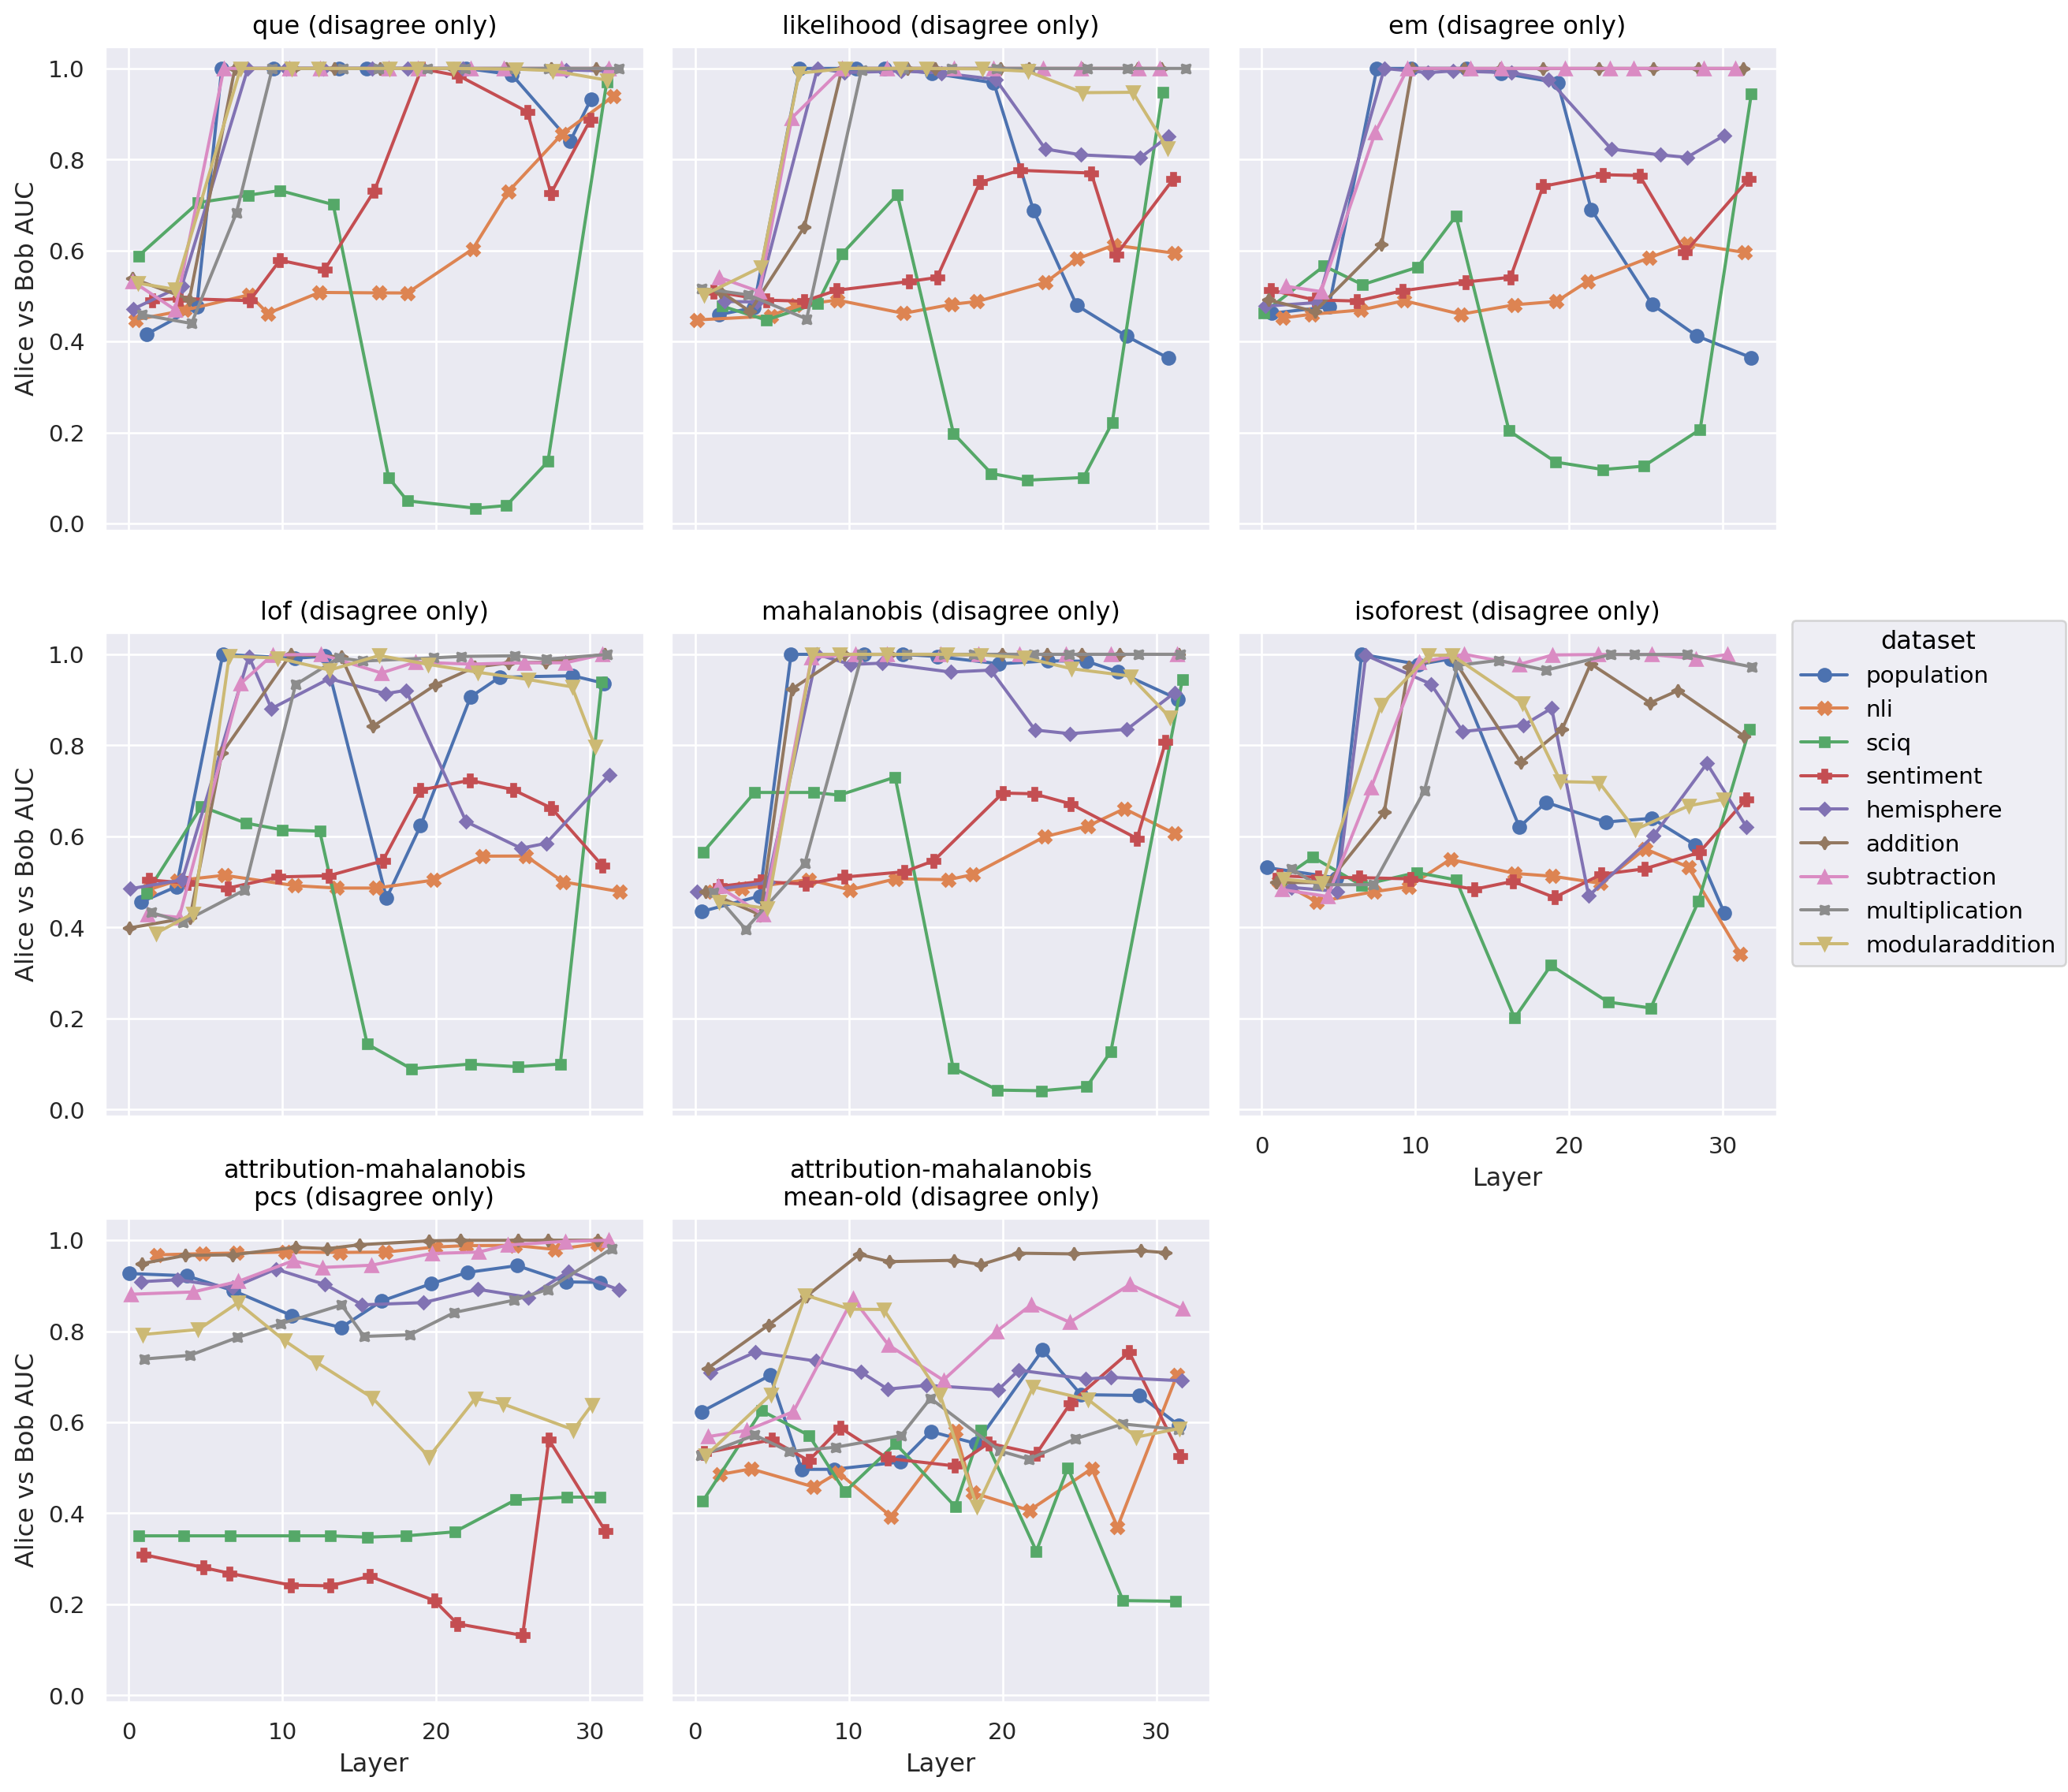

In [26]:
plot_auc_roc_by_layer_by_score(df, disagree=True)

/tmp/ipykernel_2723118/3165041549.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


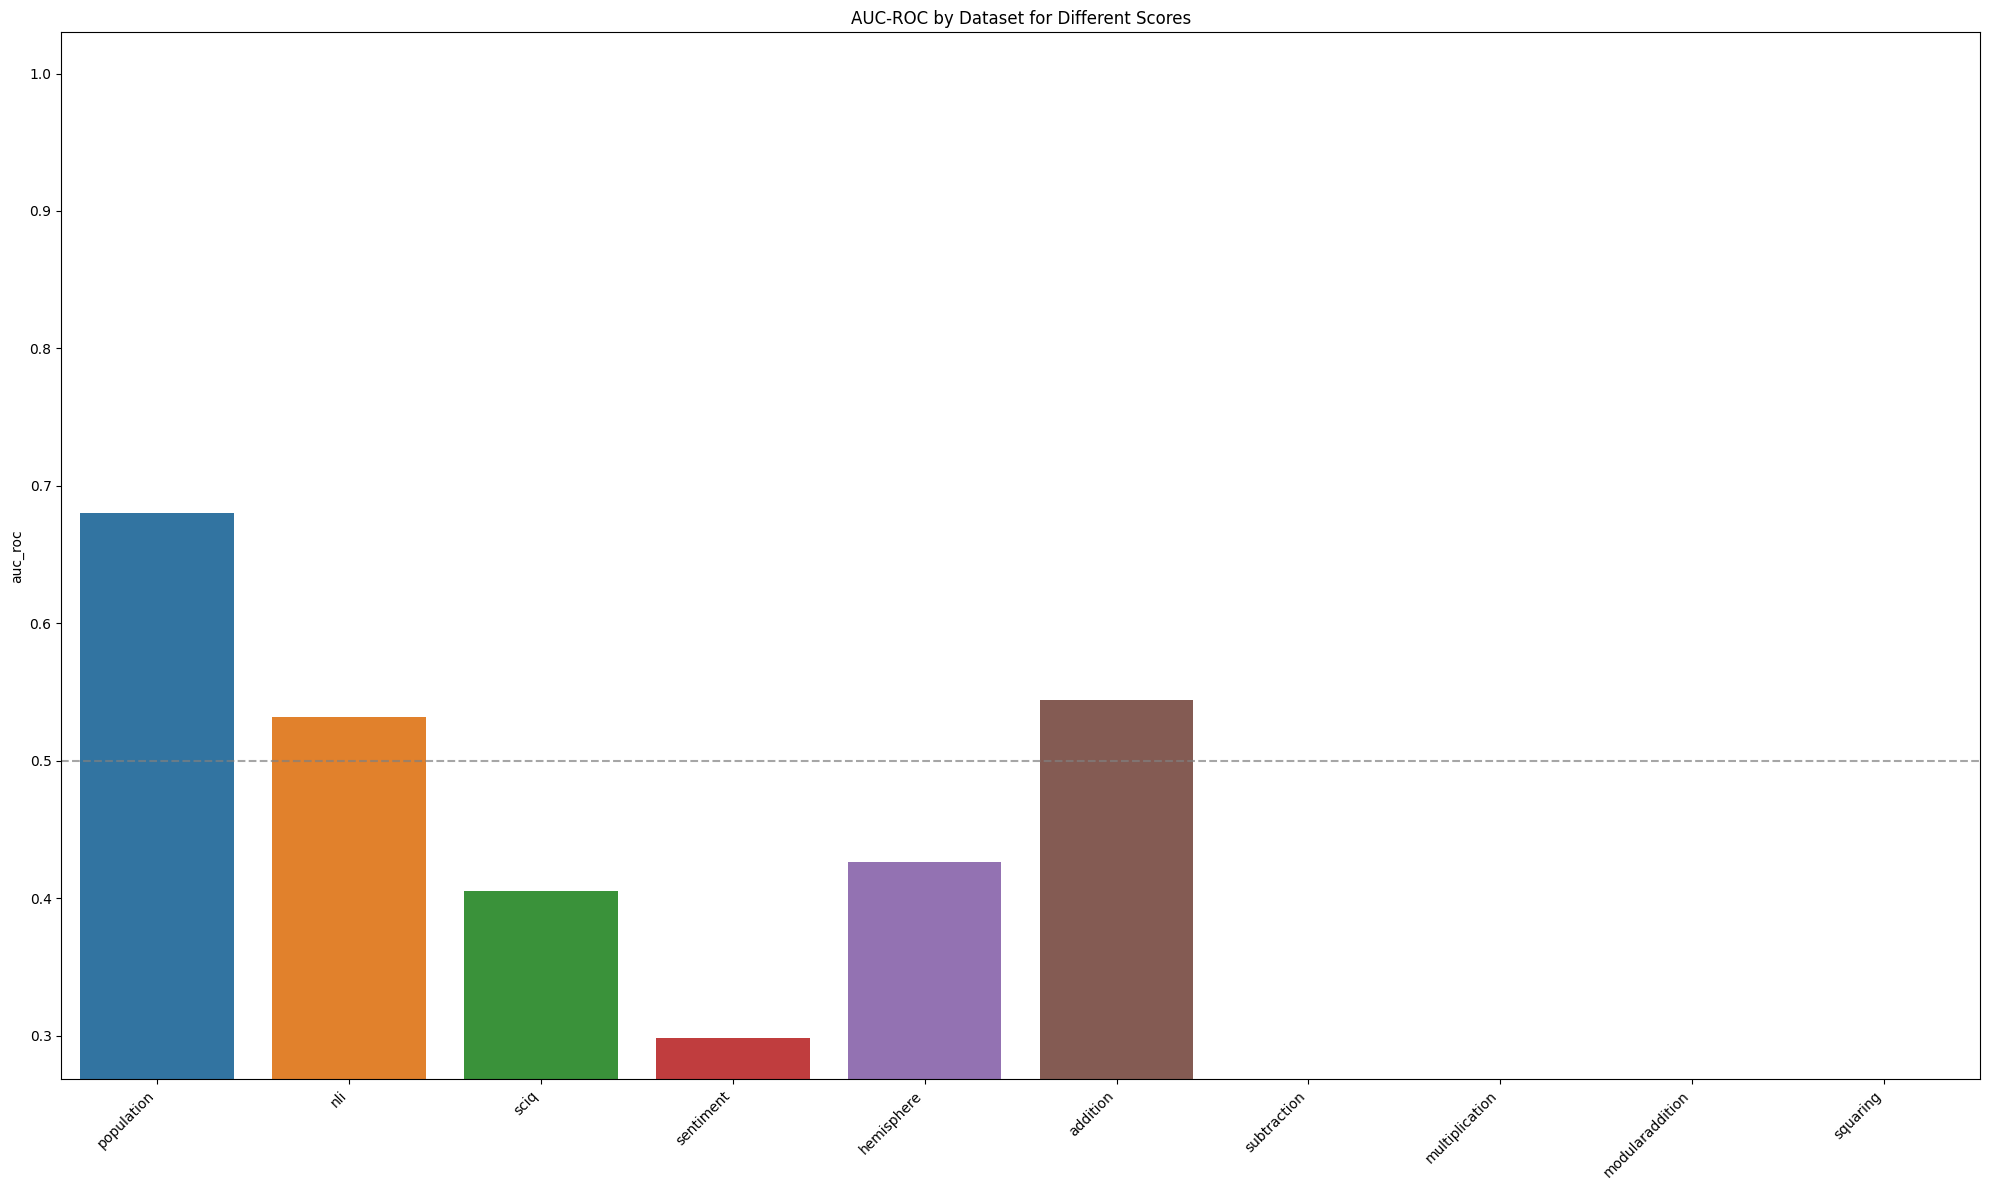

<Axes: title={'center': 'AUC-ROC by Dataset for Different Scores'}, ylabel='auc_roc'>

In [35]:
plot_auc_roc_by_layer_by_score(df, multilayer=False)

In [68]:
df[df['layer'] < 0]

,alpha,dataset,score,features,layer,random_names,auc_roc,auc_roc_agree,auc_roc_disagree
4,NaN,population,misconception,misconception_contrast,-1.0,1,0.672058,0.668954,0.676641
10,NaN,nli,probe destabilization,probe,-1.0,1,0.620295,0.619217,0.915456
33,NaN,capitals,rephrase,iterative_rephrase,-1.0,1,0.495763,0.495441,0.505207
34,NaN,population,attribution-mahalanobis,attribution,-1.0,1,0.506894,0.502520,0.518924
35,NaN,modularaddition,rephrase,iterative_rephrase,-1.0,1,0.590873,0.594124,0.586586
41,NaN,sciq,attribution-mahalanobis,attribution,-1.0,1,0.499138,0.520691,0.445976
54,NaN,population,rephrase,iterative_rephrase,-1.0,1,0.652334,0.583615,0.702839
67,NaN,nli,rephrase,iterative_rephrase,-1.0,1,0.621372,0.472515,0.852780
68,NaN,authors,rephrase,iterative_rephrase,-1.0,1,0.528140,0.505866,0.595630
83,NaN,hemisphere,rephrase,iterative_rephrase,-1.0,1,0.553151,0.548155,0.567518
